## Klasifikátory kuchýň 1

V tejto lekcii preskúmame rôzne klasifikátory na *predpovedanie národnej kuchyne na základe skupiny ingrediencií.* Pri tom sa dozvieme viac o spôsoboch, akými môžu byť algoritmy využívané na úlohy klasifikácie.

### [**Kvíz pred prednáškou**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Príprava**

Táto lekcia nadväzuje na našu [predchádzajúcu lekciu](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb), kde sme:

-   Jemne uviedli klasifikácie pomocou datasetu o všetkých úžasných kuchyniach Ázie a Indie 😋.

-   Preskúmali niektoré [slovesá dplyr](https://dplyr.tidyverse.org/) na prípravu a čistenie našich dát.

-   Vytvorili krásne vizualizácie pomocou ggplot2.

-   Ukázali, ako sa vysporiadať s nevyváženými dátami ich predspracovaním pomocou [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Demonštrovali, ako `prep` a `bake` náš recept, aby sme si overili, že funguje podľa očakávaní.

#### **Predpoklady**

Na túto lekciu budeme potrebovať nasledujúce balíky na čistenie, prípravu a vizualizáciu našich dát:

-   `tidyverse`: [tidyverse](https://www.tidyverse.org/) je [kolekcia balíkov pre R](https://www.tidyverse.org/packages), ktorá robí dátovú vedu rýchlejšou, jednoduchšou a zábavnejšou!

-   `tidymodels`: [tidymodels](https://www.tidymodels.org/) je rámec [kolekcie balíkov](https://www.tidymodels.org/packages/) na modelovanie a strojové učenie.

-   `themis`: [balík themis](https://themis.tidymodels.org/) poskytuje dodatočné kroky receptov na riešenie nevyvážených dát.

-   `nnet`: [balík nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) poskytuje funkcie na odhadovanie dopredných neurónových sietí s jednou skrytou vrstvou a na modely multinomiálnej logistickej regresie.

Môžete ich nainštalovať takto:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Alternatívne, nasledujúci skript skontroluje, či máte nainštalované balíky potrebné na dokončenie tohto modulu, a v prípade, že chýbajú, ich nainštaluje za vás.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Rozdeľte údaje na tréningovú a testovaciu množinu.

Začneme výberom niekoľkých krokov z našej predchádzajúcej lekcie.

### Odstráňte najbežnejšie ingrediencie, ktoré spôsobujú zmätok medzi rôznymi kuchyňami, pomocou `dplyr::select()`.

Každý miluje ryžu, cesnak a zázvor!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Perfektné! Teraz je čas rozdeliť údaje tak, aby 70 % údajov išlo na tréning a 30 % na testovanie. Pri rozdeľovaní údajov použijeme aj techniku `stratifikácie`, aby sme `zachovali pomer jednotlivých kuchýň` v tréningových a validačných datasetoch.

[rsample](https://rsample.tidymodels.org/), balík v Tidymodels, poskytuje infraštruktúru na efektívne rozdeľovanie a resampling údajov:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Riešenie nevyvážených údajov

Ako ste si mohli všimnúť v pôvodnej dátovej sade, ako aj v našej tréningovej sade, existuje pomerne nerovnomerné rozdelenie počtu kuchýň. Kórejské kuchyne sú *takmer* 3-krát častejšie ako thajské kuchyne. Nevývážené údaje často negatívne ovplyvňujú výkon modelu. Mnohé modely dosahujú najlepšie výsledky, keď je počet pozorovaní rovnaký, a preto majú tendenciu mať problémy s nevyváženými údajmi.

Existujú dva hlavné spôsoby, ako riešiť nevyvážené dátové sady:

-   pridanie pozorovaní do menšinovej triedy: `Over-sampling`, napríklad pomocou algoritmu SMOTE, ktorý synteticky generuje nové príklady menšinovej triedy pomocou najbližších susedov týchto prípadov.

-   odstránenie pozorovaní z väčšinovej triedy: `Under-sampling`

V našej predchádzajúcej lekcii sme ukázali, ako riešiť nevyvážené dátové sady pomocou `receptu`. Recept si môžeme predstaviť ako plán, ktorý popisuje, aké kroky by sa mali aplikovať na dátovú sadu, aby bola pripravená na analýzu údajov. V našom prípade chceme dosiahnuť rovnomerné rozdelenie počtu našich kuchýň pre našu `tréningovú sadu`. Poďme sa do toho pustiť.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Môžete samozrejme potvrdiť (pomocou prípravy a pečenia), že recept bude fungovať tak, ako očakávate - všetky označenia kuchyne majú `559` pozorovaní.

Keďže tento recept budeme používať ako predspracovanie pre modelovanie, `workflow()` za nás vykoná všetku prípravu a pečenie, takže recept nebudeme musieť manuálne odhadovať.

Teraz sme pripravení trénovať model 👩‍💻👨‍💻!

## 3. Výber klasifikátora

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Ilustrácia od @allison_horst</figcaption>


Teraz musíme rozhodnúť, ktorý algoritmus použiť na túto úlohu 🤔.

V Tidymodels poskytuje [`parsnip package`](https://parsnip.tidymodels.org/index.html) konzistentné rozhranie na prácu s modelmi naprieč rôznymi enginmi (balíčkami). Pozrite si dokumentáciu k parsnip, aby ste preskúmali [typy modelov a enginy](https://www.tidymodels.org/find/parsnip/#models) a ich zodpovedajúce [argumenty modelov](https://www.tidymodels.org/find/parsnip/#model-args). Rozmanitosť môže byť na prvý pohľad dosť mätúca. Napríklad nasledujúce metódy zahŕňajú techniky klasifikácie:

-   C5.0 modely založené na pravidlách
-   Flexibilné diskriminačné modely
-   Lineárne diskriminačné modely
-   Regularizované diskriminačné modely
-   Modely logistickej regresie
-   Modely multinomiálnej regresie
-   Modely naivného Bayesa
-   Podporné vektorové stroje
-   Najbližší susedia
-   Rozhodovacie stromy
-   Ensemble metódy
-   Neurónové siete

A zoznam pokračuje!

### **Aký klasifikátor zvoliť?**

Takže, ktorý klasifikátor by ste si mali vybrať? Často je dobrým spôsobom testovania prejsť viacerými a hľadať dobrý výsledok.

> AutoML tento problém elegantne rieši tým, že vykonáva tieto porovnania v cloude, čo vám umožňuje vybrať najlepší algoritmus pre vaše dáta. Vyskúšajte to [tu](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Výber klasifikátora však závisí aj od nášho problému. Napríklad, keď výsledok môže byť kategorizovaný do `viac ako dvoch tried`, ako v našom prípade, musíte použiť `algoritmus pre multiklasifikáciu` namiesto `binárnej klasifikácie.`

### **Lepší prístup**

Lepším spôsobom ako náhodne hádať je však riadiť sa nápadmi z tohto stiahnuteľného [ML Cheat sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). Tu zistíme, že pre náš problém s multiklasifikáciou máme niekoľko možností:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Časť Microsoftovho prehľadu algoritmov, ktorá podrobne opisuje možnosti multiklasifikácie</figcaption>


### **Úvaha**

Pozrime sa, či dokážeme logicky zhodnotiť rôzne prístupy vzhľadom na obmedzenia, ktoré máme:

-   **Hlboké neurónové siete sú príliš náročné**. Vzhľadom na náš čistý, ale minimálny dataset a fakt, že trénovanie prebieha lokálne cez notebooky, sú hlboké neurónové siete pre túto úlohu príliš náročné.

-   **Žiadny dvojtriedny klasifikátor**. Nepoužívame dvojtriedny klasifikátor, takže možnosť one-vs-all je vylúčená.

-   **Rozhodovací strom alebo logistická regresia by mohli fungovať**. Rozhodovací strom by mohol fungovať, rovnako ako multinomiálna regresia/multitriedna logistická regresia pre multitriedne dáta.

-   **Multitriedne Boosted Decision Trees riešia iný problém**. Multitriedny Boosted Decision Tree je najvhodnejší pre neparametrické úlohy, napríklad úlohy zamerané na vytváranie rebríčkov, takže pre nás nie je užitočný.

Okrem toho, predtým než sa pustíme do zložitejších modelov strojového učenia, ako sú ensemble metódy, je zvyčajne dobré začať s najjednoduchším možným modelom, aby sme získali predstavu o tom, čo sa deje. Preto v tejto lekcii začneme s modelom `multinomiálnej regresie`.

> Logistická regresia je technika používaná, keď je výstupná premenná kategóriálna (alebo nominálna). Pri binárnej logistickej regresii je počet výstupných premenných dva, zatiaľ čo pri multinomiálnej logistickej regresii je počet výstupných premenných viac ako dva. Viac informácií nájdete v [Pokročilé regresné metódy](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html).

## 4. Trénovanie a hodnotenie modelu multinomiálnej logistickej regresie

V Tidymodels, `parsnip::multinom_reg()`, definuje model, ktorý používa lineárne prediktory na predpovedanie multitriednych dát pomocou multinomiálneho rozdelenia. Pozrite si `?multinom_reg()` pre rôzne spôsoby/enginy, ktoré môžete použiť na fitovanie tohto modelu.

V tomto príklade budeme fitovať model multinomiálnej regresie cez predvolený engine [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf).

> Hodnotu pre `penalty` som vybral tak trochu náhodne. Existujú lepšie spôsoby, ako túto hodnotu zvoliť, napríklad pomocou `resamplingu` a `ladenia` modelu, o ktorých budeme hovoriť neskôr.
>
> Pozrite si [Tidymodels: Začnite](https://www.tidymodels.org/start/tuning/), ak sa chcete dozvedieť viac o ladení hyperparametrov modelu.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Skvelá práca 🥳! Teraz, keď máme recept a špecifikáciu modelu, musíme nájsť spôsob, ako ich spojiť do objektu, ktorý najprv predspracuje dáta, potom na predspracovaných dátach natrénuje model a zároveň umožní aj prípadné aktivity po spracovaní. V Tidymodels sa tento praktický objekt nazýva [`workflow`](https://workflows.tidymodels.org/) a pohodlne uchováva vaše modelovacie komponenty! Toto by sme v *Pythone* nazvali *pipelines*.

Takže poďme všetko zabaliť do workflowu!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Pracovné postupy 👌👌! **`workflow()`** môže byť nastavený podobne ako model. Takže, je čas trénovať model!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Výstup zobrazuje koeficienty, ktoré model naučil počas tréningu.

### Vyhodnotenie vytrénovaného modelu

Je čas zistiť, ako si model viedol 📏, vyhodnotením na testovacej množine! Začnime tým, že urobíme predpovede na testovacej množine.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Skvelá práca! V Tidymodels je hodnotenie výkonu modelu možné pomocou [yardstick](https://yardstick.tidymodels.org/) - balíka používaného na meranie efektívnosti modelov pomocou metrík výkonu. Ako sme to urobili v našej lekcii o logistickej regresii, začnime výpočtom matice zámien.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Pri práci s viacerými triedami je vo všeobecnosti intuitívnejšie vizualizovať to ako tepelnú mapu, napríklad takto:


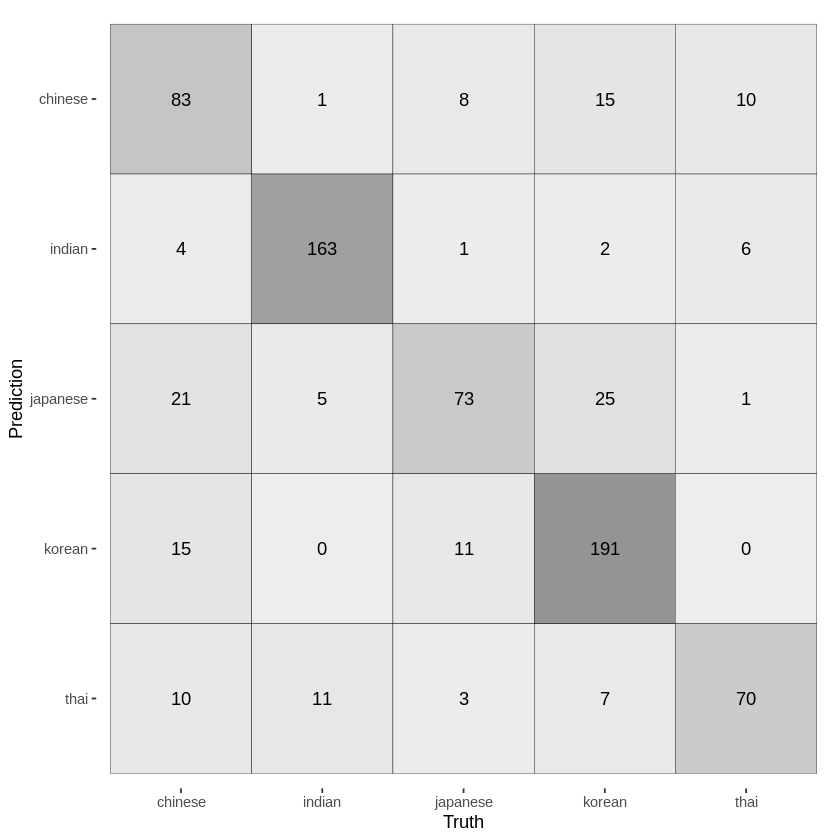

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

Tmavšie štvorce v grafe matice zámien naznačujú vysoký počet prípadov, a dúfajme, že vidíte diagonálnu líniu tmavších štvorcov, ktorá označuje prípady, kde predpovedaná a skutočná značka sú rovnaké.

Teraz vypočítajme súhrnné štatistiky pre maticu zámien.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Ak sa zameriame na niektoré metriky, ako presnosť, citlivosť, ppv, na začiatok na tom nie sme zle 🥳!

## 4. Hlbšie skúmanie

Položme si jednu jemnú otázku: Aké kritériá sa používajú na určenie konkrétneho typu kuchyne ako predpokladaného výsledku?

No, štatistické algoritmy strojového učenia, ako logistická regresia, sú založené na `pravdepodobnosti`; takže to, čo klasifikátor skutočne predpovedá, je pravdepodobnostné rozdelenie nad množinou možných výsledkov. Trieda s najvyššou pravdepodobnosťou je potom vybraná ako najpravdepodobnejší výsledok pre dané pozorovania.

Pozrime sa na to v praxi tým, že urobíme tvrdé predikcie tried a aj pravdepodobnosti.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

✅ Môžete vysvetliť, prečo si model celkom iste myslí, že prvé pozorovanie je thajské?

## **🚀Výzva**

V tejto lekcii ste použili svoje vyčistené dáta na vytvorenie modelu strojového učenia, ktorý dokáže predpovedať národnú kuchyňu na základe série ingrediencií. Nájdite si čas na preštudovanie [mnohých možností](https://www.tidymodels.org/find/parsnip/#models), ktoré Tidymodels ponúka na klasifikáciu dát, a [iných spôsobov](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models), ako prispôsobiť multinomiálnu regresiu.

#### POĎAKOVANIE:

[`Allison Horst`](https://twitter.com/allison_horst/) za vytvorenie úžasných ilustrácií, ktoré robia R prístupnejším a pútavejším. Viac ilustrácií nájdete v jej [galérii](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) a [Jen Looper](https://www.twitter.com/jenlooper) za vytvorenie pôvodnej verzie tohto modulu v Pythone ♥️

<br>
Pridal by som nejaké vtipy, ale nerozumiem jedlým slovným hračkám 😅.

<br>

Šťastné učenie,

[Eric](https://twitter.com/ericntay), Zlatý ambasádor Microsoft Learn.



---

**Upozornenie**:  
Tento dokument bol preložený pomocou služby na automatický preklad [Co-op Translator](https://github.com/Azure/co-op-translator). Aj keď sa snažíme o presnosť, upozorňujeme, že automatické preklady môžu obsahovať chyby alebo nepresnosti. Pôvodný dokument v jeho pôvodnom jazyku by mal byť považovaný za autoritatívny zdroj. Pre dôležité informácie sa odporúča profesionálny ľudský preklad. Nezodpovedáme za akékoľvek nedorozumenia alebo nesprávne interpretácie vyplývajúce z použitia tohto prekladu.
